<a href="https://colab.research.google.com/github/shoaibnadafgit/PredictingPumpFailureWithMLP/blob/main/predicting_pump_failure_with_a_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Predicting pump failures with a MLP

Notebook by Mohd.Shoaib Nadaf

**In this notebook we will show that we can learn a MLP for predicting whether a water pump will fail in a future time window or not.** The prediction / pump failure classification rate is about 97% for the following settings.

Data Source : https://www.kaggle.com/nphantawee/pump-sensor-data

The input for the MLP is a time window of some specified length of the pump sensor data (52 sensors, called "sensor_00" till "sensor_51").

The output of the MLP is a single output neuron:
- 0 means: there will be no failure (machine status "NORMAL")
- 1 means: there will be a pump failure (machine status "BROKEN"/"RECOVERING").

The following settings are used:

In [38]:
nr_examples_to_prepare = 2000
window_width_input_minutes = 60
window_width_output_minutes = 60*24

The MLP will be trained e.g. on 2000/2=1000 training samples, where the input window covers 60 minutes (1 hour of sensor data).

The MLP input vector x length will be accordingly 60 minutes x 52 sensor samples/minute = a 3120-dimensional input vector.

The MLP output vector y length is 1 (just one output neuron).
For checking whether there was a pump failure after the input window (so for generating the teacher vectors y), we check in some time window of length 60 x 24 (i.e. 1 day = 60 minutes * 24 hours), whether the machine went into state "BROKEN" or "RECOVERING".

1000 randomly extracted samples (x,y) will be used for training.

1000 randomly extracted samples (x,y) will be used for testing.

For generating one of these 2000 training samples we
- randomly choose a sample minute
- compute the input vector x from the input window starting at this minute
- compute the output vector y by checking whether in the following time window the pump failed
- combine both the input and output vector into one training sample (x,y)

# Sketch of the approach

![image.png](attachment:image.png)

# Read in the sensor and machine status data

In [39]:
import pandas
print("Your Pandas version is ", pandas.__version__)
fname = "sensor.csv"
df = pandas.read_csv( fname )

df

Your Pandas version is  1.1.4


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.21180,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.129630,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.16840,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.840280,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.21180,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.550930,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13303,13303,2018-04-10 05:43:00,2.404398,49.91319,50.99826,41.102430,619.6759,86.22668,13.09317,15.70457,15.22714,14.61227,38.86257,45.02829,21.25496,5.800808,400.6465,NaN,441.8315,443.4118,2.331672,626.0076,375.2356,822.0349,502.7365,1021.9830,587.3931,741.4294,819.2260,512.8843,874.9847,799.0316,710.1852,800.5208,804.3057,488.9588,168.0059,319.5670,241.1937,101.59700,55.20833,33.59375,52.60416,34.89583,31.510416,35.67708,33.564816,42.53472,36.16898,44.560180,160.8796,47.453700,225.4051,213.8310,NORMAL
13304,13304,2018-04-10 05:44:00,2.411285,49.78299,50.99826,41.102428,637.7344,86.08546,13.02807,15.62500,15.18374,14.61227,38.81723,45.58395,20.50380,4.948913,399.4751,NaN,441.2843,442.3607,2.318073,626.1462,374.3

In [40]:
type(df)

pandas.core.frame.DataFrame

In [41]:
# The first column has no name. Give it a name!
df.rename(columns={ df.columns[0]: "Samplenr" }, inplace = True)

In [42]:
df[:5]

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


# Show some of the rows from the .csv file

In [43]:
df.head(7)

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,15.89265,15.16204,39.29406,49.37051,32.23816,1.673484,418.9049,NaN,461.8948,461.9289,2.507935,663.4962,398.6428,872.4973,498.4064,974.6847,624.3462,739.2036,846.4617,429.6945,777.2820,700.7193,623.1481,734.3750,711.2128,438.6517,162.8758,333.7975,196.4579,90.84048,42.70833,31.77083,79.94791,30.98958,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,6,2018-04-01 00:06:00,2.455556,47.04861,53.1684,46.397568,633.3333,75.81614,13.43316,16.13136,15.65393,15.08247,38.29974,49.57146,32.00982,1.684984,420.3324,NaN,464.2402,467.5146,2.598702,667.4751,401.1847,882.7164,500.4944,981.2908,631.2756,740.9517,853.9647,458.3623,771.8188,722.5254,674.0740,707.8125,716.1951,433.5065,161.9678,330.3747,194.0652,89.23161,42.70833,32.29166,79.94791,31.25000,31.510420,43.22916,38.194440,61.92130,51.79398,39.062500,171.875

In [44]:
df.tail(3)

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
13305,13305,2018-04-10 05:45:00,2.400463,49.73958,50.99826,41.10243,638.6573,85.26878,13.23061,15.66840,15.22714,14.61227,39.01537,46.04259,20.05918,4.845504,400.7352,NaN,442.3007,441.6125,2.315775,624.9090,374.7560,827.0579,501.4452,1020.327,587.9463,740.0205,820.1917,511.3398,877.0533,790.4448,702.3148,806.7708,776.2044,485.5840,170.9258,322.9051,248.7827,93.41489,52.08333,32.81250,53.38541,33.59375,31.51042,36.19791,33.56482,42.24537,36.16898,43.40278,165.5093,47.743057,221.3542,217.0139,NORMAL
13306,13306,2018-04-10 05:46:00,2.409317,49.78299,50.99826,41.18924,631.7130,87.77045,13.05700,15.70457,15.07523,14.64120,38.71009,46.10219,19.89312,4.764001,400.7058,NaN,442.3828,437.3985,2.265469,625.1894,374.9944,825.3875,501.5267,1024.171,589.3858,739.6516,819.6889,482.7690,876.1569,791.7999,687.9630,832.8124,761.2307,480.7304,171.4491,326.3189,249.9558,93.84496,50.78125,32.29166,53.64583,33.07291,31.25000,35.67708,33.27546,41.66667,36.45833,42.53472,169.5602,47.743057,219.0394,218.1713,NORMAL
13307,13307,2018-04-10 05:47:00,2.400463,49.73958,50.99826,41.10243,633.1018,86.49679,13.12211,15.63223,15.18374,14.61227,39.90940,45.77719,19.68318,4.546461,398.3450,NaN,442.5128,445.5343,2.359693,624.0285,374.9215,821.7391,502.2059,1023.243,58.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.dtypes

Samplenr            int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

In [46]:
df.describe()

,Samplenr,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,13308.000000,13308.000000,13278.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,0.0,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000
mean,6653.500000,2.435403,48.682627,51.559426,43.666249,635.647336,77.446879,13.341402,16.208162,15.563678,15.053238,39.948661,47.744380,34.085007,7.884313,419.137418,NaN,462.369878,462.128235,2.535425,664.128255,398.308226,877.595738,495.857279,954.984040,626.218010,756.114222,850.377184,456.671821,789.425570,765.495977,661.206462,815.593992,764.774192,510.047892,164.525193,321.503152,367.914753,100.156666,47.515539,33.231821,70.692759,33.398914,33.289710,42.481825,43.526333,48.833950,45.824499,40.179880,161.847904,64.670381,217.539884,206.762174
std,3841.833026,0.059994,2.481090,1.486785,1.920299,8.481962,5.838642,0.259753,0.281225,0.269207,0.458752,3.273768,4.648401,3.496066,6.890475,7.914178,NaN,13.581533,10.503091,0.112430,5.982282,3.492186,7.994401,15.511591,21.823930,7.921410,27.237742,10.692112,47.241257,55.733491,61.393757,22.720925,87.618886,49.841836,68.138244,9.363754,17.920285,207.975436,18.880831,6.199395,4.941128,18.465211,3.605657,3.411741,8.840051,7.568736,16.236571,16.528900,4.392489,53.501399,18.717040,35.753538,26.326419
min,0.000000,2.013831,39.062500,42.838540,33.854160,590.162000,58.016950,11.733220,14.322920,14.113140,0.007234,0.203163,33.988650,6.999094,0.173840,258.360700,NaN,283.030600,284.454100,0.957606,622.181300,374.194000,821.739100,439.110400,915.566300,58.000000,420.001100,780.235800,38.332320,128.777800,637.245800,557.870400,218.750000,392.536000,340.478000,119.523500,233.286100,171.124000,0.000000,32.812500,25.000000,40.625000,25.781250,27.083330,30.989580,29.224540,30.671300,32.407406,30.960650,52.662040,39.062500,118.923600,129.340300
25%,3326.750000,2.412269,46.657990,50.998260,42.187500,631.134300,73.585435,13.170932,16.131360,15.415220,15.053530,37.836715,44.275317,32.570845,1.622604,419.101275,NaN,461.639200,458.633950,2.494318,664.061100,398.498875,877.382125,498.565000,948.487500,625.165025,739.884850,848.048600,438.754900,779.184300,708.010000,647.685200,751.041600,723.560500,459.826000,158.283600,309.872100,204.157650,89.139545,43.229160,29.947916,59.895830,30.468750,30.468750,38.020830,38.194440,39.641200,39.351850,37.326390,121.238400,50.636570,191.261600,190.682900
50%,6653.500000,2.448669,48.394100,51.822910,43.619790,636.111100,77.178000,13.346350,16.167530,15.617770,15.082470,39.654335,48.335035,34.336220,5.868630,420.151650,NaN,463.079000,462.808300,2.542200,665.754700,399.371600,879.889500,499.897750,950.144350,627.499200,766.679300,850.466500,454.852900,790.379700,751.036500,661.574000,801.562400,771.925600,478.086500,165.789900,323.229800,252.774400,101.029100,46.875000,32.552080,66.927080,32.812500,32.552080,41.406250,42.245370,45.138890,42.534721,39.351850,159.722200,60.474540,216.145800,205.150500
75%,9980.250000,2.461458,50.607640,52.560760,45.182289,640.856400,80.986810,13.5

# Which different machine states are there and how often?

In [47]:
possible_machine_states = list(df.machine_status.unique())

In [48]:
possible_machine_states

['NORMAL', nan]

In [49]:
# Get all rows where machine status was "NORMAL"
df_status_NORMAL = df[ df["machine_status"] == "NORMAL" ]

In [50]:
type(df_status_NORMAL)

pandas.core.frame.DataFrame

In [51]:
df_status_NORMAL.shape

(13307, 55)

In [52]:
nr_rows_machine_status_NORMAL = df_status_NORMAL.shape[0]

In [53]:
nr_rows_machine_status_NORMAL

13307

In [54]:
nr_rows_total = df.shape[0]

In [55]:
nr_rows_total

13308

In [56]:
percent_machine_status_NORMAL = \
    (nr_rows_machine_status_NORMAL / nr_rows_total) * 100.0

In [57]:
percent_machine_status_NORMAL

99.99248572287345

In [58]:
df_status_BROKEN = df[ df["machine_status"] == "BROKEN" ]

In [59]:
df_status_BROKEN

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status


In [60]:
nr_rows_machine_status_BROKEN = df_status_BROKEN.shape[0]

In [61]:
print("So {0} times, the pump was broken".format(nr_rows_machine_status_BROKEN))

So 0 times, the pump was broken


In [62]:
df_status_RECOVERING = df[ df["machine_status"] == "RECOVERING" ]
nr_rows_machine_status_RECOVERING = df_status_RECOVERING.shape[0]

In [63]:
percent_machine_status_RECOVERING = \
    (nr_rows_machine_status_RECOVERING / nr_rows_total) * 100.0

In [64]:
percent_machine_status_RECOVERING

0.0

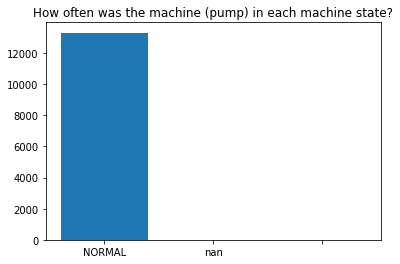

In [65]:
import matplotlib.pyplot as plt

xpos = [1,2,3]
data = [nr_rows_machine_status_NORMAL,
        nr_rows_machine_status_BROKEN,
        nr_rows_machine_status_RECOVERING]

fig, ax = plt.subplots()
ax.bar(xpos,data)
ax.set_xticks(xpos)
ax.set_xticklabels(possible_machine_states)
ax.set_title("How often was the machine (pump) in each machine state?")
plt.show()

# How long did the 7 RECOVERING phases need?

In [66]:
df_status_BROKEN

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status


In [67]:
row_numbers_machine_BROKEN = list(df_status_BROKEN["Samplenr"].values)

In [68]:
row_numbers_machine_BROKEN

[]

In [69]:
recovering_times_hours = []

for i in row_numbers_machine_BROKEN:
    print("\nMachine in status BROKEN in row: {0}".format(i) )
    
    go_further = True
    j = i
    while go_further:
        j += 1
        machine_status_in_row_j = df.iloc[j]["machine_status"]        
        if machine_status_in_row_j != "RECOVERING":
            go_further = False
            
    print("Machine went back to status {0} in row: {1}"
          .format(machine_status_in_row_j, j-i)
          )
    recovering_hours = (j-i)/60
    recovering_days  = recovering_hours / 24
    print("Machine was in RECOVERING state for {0:.1f} hours / {1:.1f} days"
          .format( recovering_hours, recovering_days )
         )
    
    recovering_times_hours.append(recovering_hours)

In [70]:
recovering_times_hours

[]

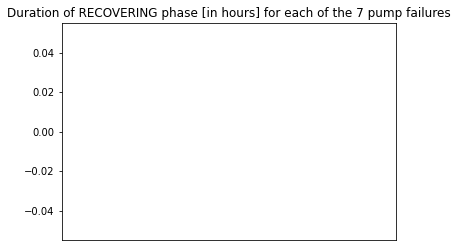

In [71]:
import matplotlib.pyplot as plt
import numpy as np

xpos = np.arange( len(recovering_times_hours) )

fig, ax = plt.subplots()
ax.bar(xpos,recovering_times_hours)
ax.set_xticks(xpos)
ax.set_xticklabels(xpos)
ax.set_title("Duration of RECOVERING phase [in hours] for each of the 7 pump failures")
plt.show()

In [72]:
min(recovering_times_hours)

ValueError: ignored

In [73]:
max(recovering_times_hours)

ValueError: ignored

# Visualize some of the sensor data

In [74]:
df["sensor_17"]

0        466.3284
1        466.3284
2        459.6364
3        460.8858
4        468.2206
           ...   
13303    443.4118
13304    442.3607
13305    441.6125
13306    437.3985
13307    445.5343
Name: sensor_17, Length: 13308, dtype: float64

In [75]:
type( df["sensor_17"] )

pandas.core.series.Series

In [76]:
sensor_values = list( df["sensor_17"] )

In [77]:
type(sensor_values)

list

In [78]:
len(sensor_values)

13308

In [79]:
sensor_values[:10]

[466.3284,
 466.3284,
 459.6364,
 460.8858,
 468.2206,
 461.9289,
 467.5146,
 463.8936,
 461.546,
 468.8477]

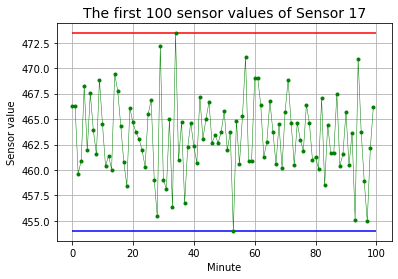

In [80]:
import matplotlib.pyplot as plt

some_few_values = sensor_values[:100]
min_val = min(some_few_values)
max_val = max(some_few_values)

plt.plot( some_few_values, color="green", linestyle="-",
          marker=".", linewidth=0.5 )
plt.hlines(min_val, 0,100, color="blue")
plt.hlines(max_val, 0,100, color="red")
plt.xlabel("Minute", fontsize=10)
plt.ylabel("Sensor value", fontsize=10)
plt.title("The first 100 sensor values of Sensor 17", fontsize=14)
plt.grid()
#plt.savefig("sensor_17.png")
plt.show()

# Fill data gaps (NaN values)

How many missing values are there in total?

In [85]:
df.isna().sum().sum()

13366

In [86]:
df.isna().sum()

Samplenr              0
timestamp             0
sensor_00             0
sensor_01            30
sensor_02             0
sensor_03             0
sensor_04             0
sensor_05             0
sensor_06             0
sensor_07             0
sensor_08             0
sensor_09             0
sensor_10             0
sensor_11             0
sensor_12             0
sensor_13             0
sensor_14             0
sensor_15         13308
sensor_16             0
sensor_17             0
sensor_18             0
sensor_19             0
sensor_20             0
sensor_21             0
sensor_22             0
sensor_23             0
sensor_24             0
sensor_25             1
sensor_26             1
sensor_27             1
sensor_28             1
sensor_29             1
sensor_30             1
sensor_31             1
sensor_32             1
sensor_33             1
sensor_34             1
sensor_35             1
sensor_36             1
sensor_37             1
sensor_38             1
sensor_39       

In [87]:
only_numerical_cols = df.iloc[:,2:54]

In [88]:
only_numerical_cols

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889
1,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889
2,2.444734,47.35243,53.21180,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.129630,241.3194,203.7037
3,2.460474,47.09201,53.16840,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.840280,240.4514,203.1250
4,2.445718,47.13541,53.21180,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.550930,242.1875,201.3889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13303,2.404398,49.91319,50.99826,41.102430,619.6759,86.22668,13.09317,15.70457,15.22714,14.61227,38.86257,45.02829,21.25496,5.800808,400.6465,NaN,441.8315,443.4118,2.331672,626.0076,375.2356,822.0349,502.7365,1021.9830,587.3931,741.4294,819.2260,512.8843,874.9847,799.0316,710.1852,800.5208,804.3057,488.9588,168.0059,319.5670,241.1937,101.59700,55.20833,33.59375,52.60416,34.89583,31.510416,35.67708,33.564816,42.53472,36.16898,44.560180,160.8796,47.453700,225.4051,213.8310
13304,2.411285,49.78299,50.99826,41.102428,637.7344,86.08546,13.02807,15.62500,15.18374,14.61227,38.81723,45.58395,20.50380,4.948913,399.4751,NaN,441.2843,442.3607,2.318073,626.1462,374.3383,824.6510,502.2720,1025.1060,591.1661,743.4790,820.6304,518.5290,871.7017,804.1895,692.5926,824.9999,781.3151,484.3348,169.4916,322.5341,246.5651,100.83490,53.64583,33.59375,52.60416,33.85416,31.510416,36.19791,33.564816,42.53472,36.16898,43.981480,

In [89]:
df.describe()

,Samplenr,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,13308.000000,13308.000000,13278.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,0.0,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13308.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000
mean,6653.500000,2.435403,48.682627,51.559426,43.666249,635.647336,77.446879,13.341402,16.208162,15.563678,15.053238,39.948661,47.744380,34.085007,7.884313,419.137418,NaN,462.369878,462.128235,2.535425,664.128255,398.308226,877.595738,495.857279,954.984040,626.218010,756.114222,850.377184,456.671821,789.425570,765.495977,661.206462,815.593992,764.774192,510.047892,164.525193,321.503152,367.914753,100.156666,47.515539,33.231821,70.692759,33.398914,33.289710,42.481825,43.526333,48.833950,45.824499,40.179880,161.847904,64.670381,217.539884,206.762174
std,3841.833026,0.059994,2.481090,1.486785,1.920299,8.481962,5.838642,0.259753,0.281225,0.269207,0.458752,3.273768,4.648401,3.496066,6.890475,7.914178,NaN,13.581533,10.503091,0.112430,5.982282,3.492186,7.994401,15.511591,21.823930,7.921410,27.237742,10.692112,47.241257,55.733491,61.393757,22.720925,87.618886,49.841836,68.138244,9.363754,17.920285,207.975436,18.880831,6.199395,4.941128,18.465211,3.605657,3.411741,8.840051,7.568736,16.236571,16.528900,4.392489,53.501399,18.717040,35.753538,26.326419
min,0.000000,2.013831,39.062500,42.838540,33.854160,590.162000,58.016950,11.733220,14.322920,14.113140,0.007234,0.203163,33.988650,6.999094,0.173840,258.360700,NaN,283.030600,284.454100,0.957606,622.181300,374.194000,821.739100,439.110400,915.566300,58.000000,420.001100,780.235800,38.332320,128.777800,637.245800,557.870400,218.750000,392.536000,340.478000,119.523500,233.286100,171.124000,0.000000,32.812500,25.000000,40.625000,25.781250,27.083330,30.989580,29.224540,30.671300,32.407406,30.960650,52.662040,39.062500,118.923600,129.340300
25%,3326.750000,2.412269,46.657990,50.998260,42.187500,631.134300,73.585435,13.170932,16.131360,15.415220,15.053530,37.836715,44.275317,32.570845,1.622604,419.101275,NaN,461.639200,458.633950,2.494318,664.061100,398.498875,877.382125,498.565000,948.487500,625.165025,739.884850,848.048600,438.754900,779.184300,708.010000,647.685200,751.041600,723.560500,459.826000,158.283600,309.872100,204.157650,89.139545,43.229160,29.947916,59.895830,30.468750,30.468750,38.020830,38.194440,39.641200,39.351850,37.326390,121.238400,50.636570,191.261600,190.682900
50%,6653.500000,2.448669,48.394100,51.822910,43.619790,636.111100,77.178000,13.346350,16.167530,15.617770,15.082470,39.654335,48.335035,34.336220,5.868630,420.151650,NaN,463.079000,462.808300,2.542200,665.754700,399.371600,879.889500,499.897750,950.144350,627.499200,766.679300,850.466500,454.852900,790.379700,751.036500,661.574000,801.562400,771.925600,478.086500,165.789900,323.229800,252.774400,101.029100,46.875000,32.552080,66.927080,32.812500,32.552080,41.406250,42.245370,45.138890,42.534721,39.351850,159.722200,60.474540,216.145800,205.150500
75%,9980.250000,2.461458,50.607640,52.560760,45.182289,640.856400,80.986810,13.5

In [90]:
fill_value = -1.0
data_with_gaps_filled = df.fillna( fill_value )

In [91]:
data_with_gaps_filled.isna().sum()

Samplenr          0
timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0


# Prepare data for training and testing

## How to get an example input window

In [92]:
sensordata_cols_only = data_with_gaps_filled.iloc[:,2:54]

In [93]:
sensordata_cols_only

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,-1.0,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889
1,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,-1.0,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889
2,2.444734,47.35243,53.21180,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,-1.0,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.129630,241.3194,203.7037
3,2.460474,47.09201,53.16840,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,-1.0,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.840280,240.4514,203.1250
4,2.445718,47.13541,53.21180,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,-1.0,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.550930,242.1875,201.3889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13303,2.404398,49.91319,50.99826,41.102430,619.6759,86.22668,13.09317,15.70457,15.22714,14.61227,38.86257,45.02829,21.25496,5.800808,400.6465,-1.0,441.8315,443.4118,2.331672,626.0076,375.2356,822.0349,502.7365,1021.9830,587.3931,741.4294,819.2260,512.8843,874.9847,799.0316,710.1852,800.5208,804.3057,488.9588,168.0059,319.5670,241.1937,101.59700,55.20833,33.59375,52.60416,34.89583,31.510416,35.67708,33.564816,42.53472,36.16898,44.560180,160.8796,47.453700,225.4051,213.8310
13304,2.411285,49.78299,50.99826,41.102428,637.7344,86.08546,13.02807,15.62500,15.18374,14.61227,38.81723,45.58395,20.50380,4.948913,399.4751,-1.0,441.2843,442.3607,2.318073,626.1462,374.3383,824.6510,502.2720,1025.1060,591.1661,743.4790,820.6304,518.5290,871.7017,804.1895,692.5926,824.9999,781.3151,484.3348,169.4916,322.5341,246.5651,100.83490,53.64583,33.59375,52.60416,33.85416,31.510416,36.19791,33.564816,42.53472,36.16898,43.

Scale data column-wise to feature range [0,1]. If all inputs are in the same range, it makes it easier for a MLP to learn.

In [94]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler with feature range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_sensor_data = scaler.fit_transform(sensordata_cols_only)

In [95]:
scaled_sensor_data

array([[0.89473872, 0.85958546, 0.83275212, ..., 0.4773408 , 0.63064212,
        0.57880138],
       [0.89473872, 0.85958546, 0.83275212, ..., 0.4773408 , 0.63064212,
        0.57880138],
       [0.85380246, 0.86424015, 0.83275212, ..., 0.4733203 , 0.62615576,
        0.58542136],
       ...,
       [0.76608274, 0.90690751, 0.65505194, ..., 0.33863502, 0.57456549,
        0.6234865 ],
       [0.78362629, 0.90768341, 0.65505194, ..., 0.33863502, 0.56858402,
        0.62679648],
       [0.76608274, 0.90690751, 0.65505194, ..., 0.        , 0.        ,
        0.        ]])

In [96]:
window_width_input_minutes = 60
window_width_output_minutes = 60*24

In [97]:
start_minute = 0
a_single_input_window = scaled_sensor_data[start_minute:start_minute+window_width_input_minutes]

In [98]:
type(a_single_input_window)

numpy.ndarray

In [99]:
# <a_single_input_window> contains the data for 60 minutes
# for each of the 52 sensors
a_single_input_window.shape

(60, 52)

In [100]:
# Map window to a vector, since we need a 1D input for the MLP
a_single_input_vector = a_single_input_window.flatten()

In [101]:
a_single_input_vector.shape

(3120,)

## How to check whether the pump failed in some time window after the input window

In [120]:
def check_for_pump_failure(start, stop):
    """
    Returns 1, if the pump failed in time window
    (start,stop)
    
    Returns 0, else.
    """
    for minute in range(start,stop):
        # get the corresponding row from the data
        machine_state_in_this_minute = df["machine_status"].iloc[minute]
        if machine_state_in_this_minute in ["BROKEN", "RECOVERING"]:
            return 1
    
    return 0

 

In [109]:
row_numbers_machine_BROKEN

[]

In [119]:
 check_for_pump_failure(0,17000)

IndexError: ignored

In [121]:
check_for_pump_failure(17000,17200)

IndexError: ignored

In [ ]:
check_for_pump_failure(20000,30000)

In [ ]:
check_for_pump_failure(65000,69318)

In [ ]:
check_for_pump_failure(65000,69319)

## Prepare example data

In [122]:
# Max row nr such that input window and output window
# still fit into the time series data?
max_row_nr = nr_rows_total-window_width_input_minutes-window_width_output_minutes

# collect the desired number of (input_vec,output_vec) examples
training_pairs = []
for example_nr in range(0,nr_examples_to_prepare):
    
    # show progress
    if example_nr % 100 == 0:
        print("Collected examples so far:", example_nr)
    
    # 1. guess a random minute
    found_example_where_pump_worked_in_input_window = False
    while not found_example_where_pump_worked_in_input_window:
    
        rnd_minute = np.random.randint(0,max_row_nr)
        
        # Make sure, the input window does not cover
        # already a phase where the machine is broken:
        # We want examples where the input window covers
        # a normal state and we want to predict whether
        # the pump will fail or not in the next time window
        # We do NOT want to collect examples where the machine is
        # already BROKEN in the input window
        # (could be too easy to predict whether the machine
        #  will be broken in the future as well)
        start = rnd_minute
        stop  = start+window_width_input_minutes
        if check_for_pump_failure(start,stop)==0:
            found_example_where_pump_worked_in_input_window = True
            
    
    # 2. get the input vector from the 2D sensor matrix data
    a_single_input_window = scaled_sensor_data[rnd_minute:rnd_minute+window_width_input_minutes]
    a_single_input_vector = a_single_input_window.flatten()
    
    # 3. check whether in time range
    #    (rnd_minute+window_width_input_minutes,
    #     rnd_minute+window_width_input_minutes+window_width_output_minutes)
    #    the pump failed
    start = rnd_minute+window_width_input_minutes
    stop  = rnd_minute+window_width_input_minutes+window_width_output_minutes
    output_value = check_for_pump_failure(start,stop)
    
    # 4. add a new training pair to list of training pairs
    training_pairs.append( (a_single_input_vector, output_value) )
    
    

Collected examples so far: 0
Collected examples so far: 100
Collected examples so far: 200
Collected examples so far: 300
Collected examples so far: 400
Collected examples so far: 500
Collected examples so far: 600
Collected examples so far: 700
Collected examples so far: 800
Collected examples so far: 900
Collected examples so far: 1000
Collected examples so far: 1100
Collected examples so far: 1200
Collected examples so far: 1300
Collected examples so far: 1400
Collected examples so far: 1500
Collected examples so far: 1600
Collected examples so far: 1700
Collected examples so far: 1800
Collected examples so far: 1900


In [162]:
len(training_pairs)

2000

## Prepare a large example data matrix D from the list of training pairs

In [163]:
input_vec_len = training_pairs[0][0].shape[0]
output_vec_len = 1


D = np.zeros( (nr_examples_to_prepare, input_vec_len+output_vec_len))
print("Shape of D is", D.shape)

# Fill data matrix D with input vec + output vec in each row
for nr in range(0,nr_examples_to_prepare):
    (x,y) = training_pairs[nr]
    D[nr,0:input_vec_len] = x
    D[nr,input_vec_len]   = y

Shape of D is (2000, 3121)


## From example data matrix get train and test matrices

In [164]:
nr_train_samples = int(nr_examples_to_prepare/2)
x_train = D[0:nr_train_samples, 0:input_vec_len]
y_train = D[0:nr_train_samples, input_vec_len]

In [165]:
x_train.shape

(1000, 3120)

In [166]:
y_train.shape

(1000,)

In [167]:
x_test = D[nr_train_samples:, 0:input_vec_len]
y_test = D[nr_train_samples:, input_vec_len]

In [168]:
x_test.shape

(1000, 3120)

In [169]:
y_test.shape

(1000,)

# Build MLP and train it

In [172]:
import tensorflow
tensorflow.__version__

'2.3.0'

Jetzt bauen wir das MLP mit Keras zusammen!

In [173]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Dense(200, activation='relu', input_shape=(input_vec_len,)) )
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.build()

In [133]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               624200    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 632,281
Trainable params: 632,281
Non-trainable params: 0
_________________________________________________________________


Jetzt trainieren wir das Modell!

In [134]:
history = model.fit(x_train, y_train, epochs=3000)

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 502/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 503/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 504/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 505/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 506/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 507/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 508/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 509/3000
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 510/3000
32/32 [==============================] - 0s

In [139]:
type(history)

tensorflow.python.keras.callbacks.History

In [140]:
type(history.history)

dict

In [141]:
history.history["loss"][:20]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

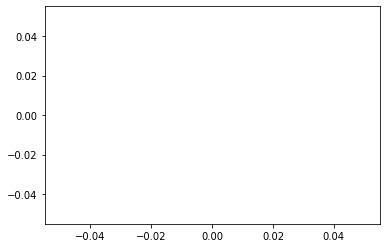

In [142]:
plt.plot(history.history["loss"])
plt.show()

# Test the final MLP

In [174]:
preds = model.predict(x_test)

In [175]:
preds.shape

(1000, 1)

In [176]:
y_test.shape

(1000,)

In [177]:
preds = preds.flatten()

In [161]:
preds.shape

(1000,)

In [178]:
preds[:20]

array([0.46693444, 0.4552269 , 0.41625047, 0.32505995, 0.45341194,
       0.34837136, 0.57910484, 0.33552396, 0.36028346, 0.22455958,
       0.18694893, 0.26459873, 0.5464326 , 0.23329723, 0.3997138 ,
       0.20854053, 0.3730018 , 0.47341233, 0.2337233 , 0.497915  ],
      dtype=float32)

In [179]:
min(preds)

-0.06463766

In [180]:
max(preds)

0.77926284

In [183]:
pump_failure_in_future_window = 0
correctly_predicted_pump_failures = 0
correctly_predicted = 0
nr_test_samples = preds.shape[0]

tp = 0
tn = 0
fp = 0
fn = 0

for test_nr in range(0,nr_test_samples):
    ground_truth_output = y_test[test_nr]
    if preds[test_nr] < 0.5:
        predicted_output = 0.0
    else:
        predicted_output = 1.0
    print("Test example #{0}: ground truth vs. predicted machine status: {1} vs. {2}"
          .format(test_nr, ground_truth_output, predicted_output ))
    
    if predicted_output == ground_truth_output:
        correctly_predicted +=1
        
    if ground_truth_output==1:
        pump_failure_in_future_window += 1
        if predicted_output == ground_truth_output:
            correctly_predicted_pump_failures +=1
            
    if ground_truth_output==1:
        if predicted_output == ground_truth_output:
            # True positive:
            # There was a pump failure
            # and the MLP predictor predicted it
            tp+=1
        else:
            # False negative:
            # There was a pump failure
            # BUT the MLP predictor predicted it not
            fn+=1
            
    if ground_truth_output==0:        
        if predicted_output == ground_truth_output:
            # True negative:
            # There was no pump failure
            # and the MLP predictor predicted no pump failure
            tn+=1
        else:
            # False positive:
            # There was no pump failure
            # BUT the MLP predictor predicted a pump failure
            fp+=1
            
        
correct_classification_percent = (correctly_predicted/nr_test_samples)*100.0
print("\nCorrectly predicted {0} of {1} test examples --> {2}%"
      .format(correctly_predicted, nr_test_samples, correct_classification_percent))

print("\nIf there was really a pump failure in the future window,\n"
      "the MLP could predict it in {0} of the {1} pump failure (in future window) example cases."
      .format(correctly_predicted_pump_failures, pump_failure_in_future_window))

print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)

Test example #0: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #1: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #2: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #3: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #4: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #5: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #6: ground truth vs. predicted machine status: 0.0 vs. 1.0
Test example #7: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #8: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #9: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #10: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #11: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #12: ground truth vs. predicted machine status: 0.0 vs. 1.0
Test example #13: ground truth vs. predicted machine status: 

In [186]:
precision = tp/(tp+fp)
#recall = tp/(tp+fn)
print("Precision: {0:.2f}".format(precision))
#print("Recall   : {0:.2f}".format(recall))

Precision: 0.00


# Conclusion

In [187]:
print("The machine status can be predicted with an accuracy of {0}%".format(correct_classification_percent)) 

The machine status can be predicted with an accuracy of 87.4%
